# ML - Assignment 1 : Bike prediction

In [1]:
#pip install xgboost

In [46]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

dateformat_train = "%Y-%m-%d %H:%M:%S"
dateformat_test = "%d-%m-%Y %H:%M"
# ---------------------------------------------------------
# Custom RMSLE Function
# ---------------------------------------------------------
def rmsle(y_true, y_pred):
    # Safety for RMSLE
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

# ---------------------------------------------------------
# Model Evaluation
# ---------------------------------------------------------
def evaluate(y_test, y_pred):
    results = {
        "RMSLE": rmsle(y_test, y_pred),
        #"RMSLE-Sklearn": np.sqrt(mean_squared_log_error(y_test, y_pred)),
        #"RMSLE-GPT" : mean_squared_log_error(y_test, y_pred)**0.5,
        #"RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        #"MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }
    return results

def parse_datetime(x):
    for fmt in ("%Y-%m-%d %H:%M:%S", "%d-%m-%Y %H:%M"):
        try:
            return pd.to_datetime(x, format=fmt)
        except:
            pass
    return pd.to_datetime(x)   # fallback

def show_distinct(df):
    selected = ["season", "weather", "holiday", "workingday"]
    print("-"*40)
    print(' Column Distinct Values : \n')
    for col in df.columns:
        if col in selected:
            print(f"Column : {col}, Distinct values: {df[col].nunique()}, Values: {df[col].unique()}")
        else :
            print(f"Column : {col}, Distinct values: {df[col].nunique()}")
        #print(df[col].value_counts())

def show_Missing(df):
    print("-"*40)
    print(f' Missing values : \n{df.isna().sum()}')
    print("-"*40)

def show_datatypes(df):
    print("-"*40)
    print(f' Data Types : \n\n{df.info()}')
    print("-"*40)

def show_dates(df):
    df2 = df.copy()    # copies df into df2
    df2["datetime"] = pd.to_datetime(
        df2["datetime"],
        dayfirst=True,
        errors="coerce"
    )
    df2 = df2.sort_values("datetime")
    print("-"*40)
    print("StartDate :", df2["datetime"].iloc[0])
    print("EndDate  :", df2["datetime"].iloc[-1])

In [47]:
# ------------------------------------------------------------------
# Load training data
# ------------------------------------------------------------------
# read training data set
print('1. Reading training data...')
df = pd.read_csv("bike_train.csv")
#df.head(5)

display(df.head())

print(f' Shape : {df.shape}' )
print(f' Column # : {len(df.columns)}' )
print(' Columns : ', list(df.columns))


1. Reading training data...


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2012-07-15 7:00:00,3,0,0,1,28.70000,33.335000,79,6.003200,17,30,47
1,2012-08-14 15:00:00,3,0,1,1,33.62000,37.880000,46,15.001300,84,199,283
2,2011-02-06 6:00:00,1,0,0,1,10.66000,12.880000,60,15.001300,0,1,1
3,2012-05-06 17:00:02,2,0,0,2,26.42506,30.566166,61,9.512288,198,330,531
4,2012-01-09 2:00:00,1,0,1,1,9.84000,12.120000,56,8.998100,2,3,5


 Shape : (10450, 12)
 Column # : 12
 Columns :  ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']


## Q1. Examine dataset size, missing values, and feature types.
Ans : <ul>
     <li>Dataset size : Rows = 10450 , columns = 12
     <li>Missing values = NO
     <li>Feature types<ol>
        <li>datatime is string combining date and time.
        <li>categorical - Season & Weather
        <li>Binary - holiday, workingday
        <li>Continueous/Numeric - temp,atemp,windspeed, humedity
    </ol></ul>

In [48]:
print('\n--------- Describe Data ---------')
display(df.describe())

show_datatypes(df)

show_Missing(df)

show_distinct(df)

show_dates(df)


--------- Describe Data ---------


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000,10450.000000
mean,2.507943,0.028804,0.675694,1.413876,20.191700,23.605793,61.924211,12.765259,35.869091,154.511675,190.410526
std,1.116946,0.167263,0.468137,0.632258,7.792683,8.478045,19.245193,8.102821,49.629436,150.861267,181.038755
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,35.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.450050,16.000000,117.000000,143.000000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,49.000000,221.000000,283.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10450 non-null  object 
 1   season      10450 non-null  int64  
 2   holiday     10450 non-null  int64  
 3   workingday  10450 non-null  int64  
 4   weather     10450 non-null  int64  
 5   temp        10450 non-null  float64
 6   atemp       10450 non-null  float64
 7   humidity    10450 non-null  int64  
 8   windspeed   10450 non-null  float64
 9   casual      10450 non-null  int64  
 10  registered  10450 non-null  int64  
 11  count       10450 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 979.8+ KB
 Data Types : 

None
----------------------------------------
----------------------------------------
 Missing values : 
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp      

### Q2. Visualize relationships between key features and the target variable (count).

    - Count is approx. sum of casual & registered. So ignored "casual & registered" columns from features list
    - Features are mix of categorical and numerical values.ng graph again
    - plotting graph againest count will give that info


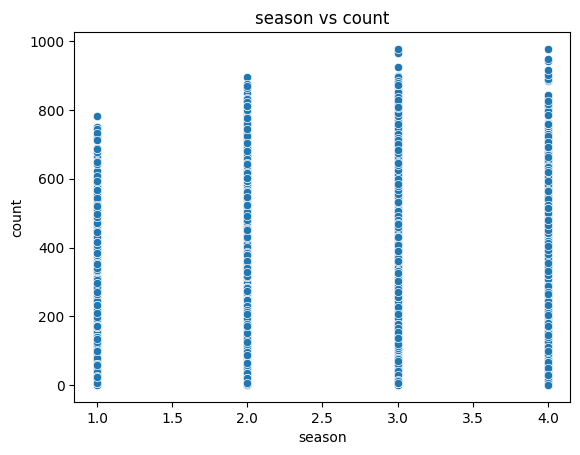

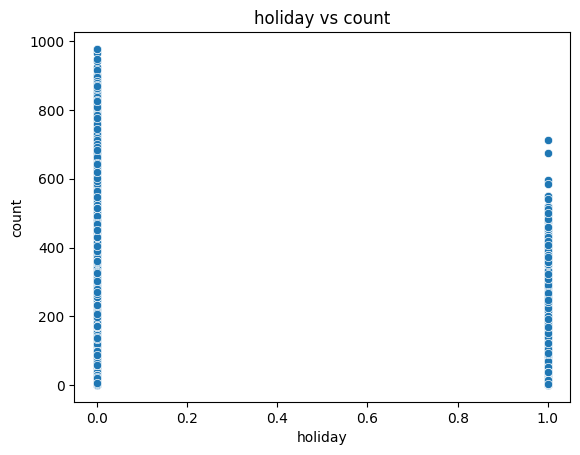

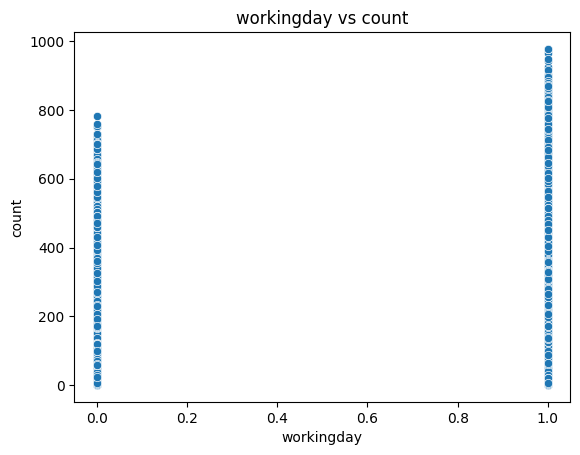

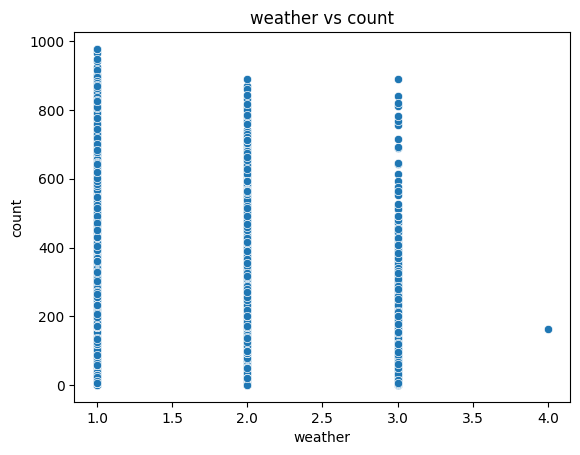

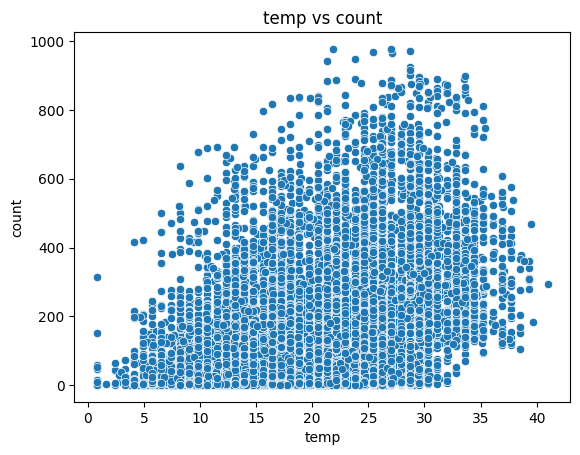

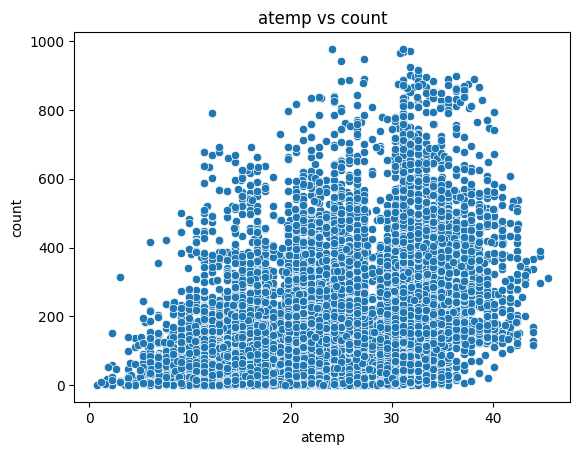

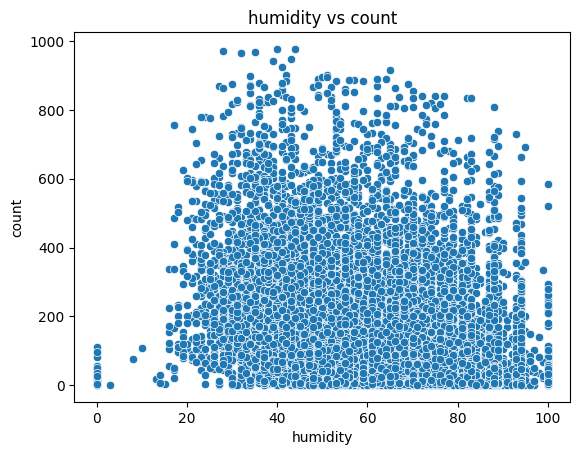

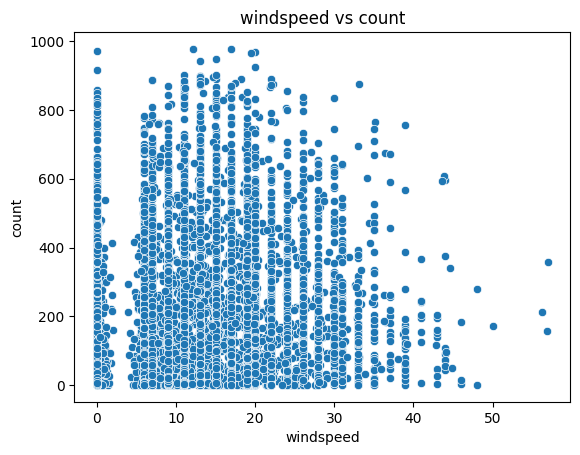

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

target = "count"

exclude_cols = ["count", "casual", "registered"]   # columns to exclude

for col in df.select_dtypes(include="number").columns:
    if col not in exclude_cols:
        sns.scatterplot(x=df[col], y=df[target])
        plt.title(f"{col} vs {target}")
        plt.show()

### Q3. Suggest which variables are likely to be most informative.

 -  Heatmap shows which numeric columns correlate most with the target and with each other
 -  weather, season, temp & humidity are useful to determine weather condition which impacts bike booking
 -  workingday & date time (which has hour) are more crucial to determine peak hours.

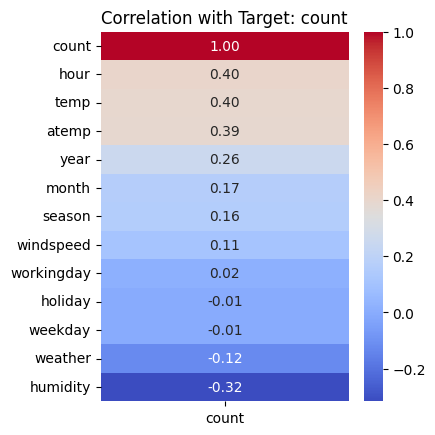

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df_temp = df.copy()
df_temp["datetime"] = pd.to_datetime(df_temp["datetime"], format=dateformat_train)

# Base components
df_temp["hour"] = df_temp["datetime"].dt.hour
df_temp["weekday"] = df_temp["datetime"].dt.weekday
df_temp["month"] = df_temp["datetime"].dt.month
df_temp["year"] = df_temp["datetime"].dt.year

exclude_cols = [ "casual", "registered"]   # columns to exclude
# correlation matrix
corr = df_temp.drop(columns=exclude_cols, errors="ignore").corr(numeric_only=True)

#plt.figure(figsize=(12, 8))
#sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
#plt.title("Correlation Heatmap")
#plt.show()

target = "count"

plt.figure(figsize=(4, len(df.columns) * 0.4))
sns.heatmap(
    corr[[target]].sort_values(by=target, ascending=False),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title(f"Correlation with Target: {target}")
plt.show()

## Q4. Feature Engineering

 - Derived New features - day, month, year, hour, working day from datetime. Using hour & workingday created new feature "is_working_peak"
 - hour has cyclic behavior i.e. 23 and 0 are close. So encoded it as - 'hour_sin', 'hour_cos' to derive new features.
 - temp_humidity derived from temp & humedity
 - Transaformations - performed numeric & categorical transfomation on features. 


In [7]:
# ------------------------------------------------------------------
# Feature Engineering
# ------------------------------------------------------------------
def add_datetime_features(df, dateformat):

    df["datetime"] = pd.to_datetime(df["datetime"], format=dateformat)

    # Base components
    df["hour"] = df["datetime"].dt.hour
    df["weekday"] = df["datetime"].dt.weekday
    df["month"] = df["datetime"].dt.month
    df["year"] = df["datetime"].dt.year

    # Cyclic Encoding
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["weekday_sin"] = np.sin(2 * np.pi * df["weekday"] / 7)
    df["weekday_cos"] = np.cos(2 * np.pi * df["weekday"] / 7)

    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # Binary features
   # df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
    df["is_rush_hour"] = df["hour"].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)

    # Interaction features
    df['temp_humidity'] = df['temp'] * (1 - df['humidity'])
    #df["feels_like_diff"] = df["atemp"] - df["temp"]

    return df


df = add_datetime_features(df, dateformat_train)

target = "count"

#numeric_poly = ["temp", "atemp"]

numeric_features = [
    "temp", "humidity", "windspeed",
    "hour_sin", "hour_cos",
    "weekday_sin", "weekday_cos",
    "month_sin", "month_cos",
    "temp_humidity"
]

categorical_features = [
     "weather", "holiday", "workingday",
    "year", "is_rush_hour"
]

all_features = numeric_features + categorical_features
X = df[all_features]

# CRITICAL FIX: LOG TARGET
y = np.log1p(df[target])
# y = df[target]

print(' X Features  : ', all_features)
X.head()
X.shape

 X Features  :  ['temp', 'humidity', 'windspeed', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'temp_humidity', 'weather', 'holiday', 'workingday', 'year', 'is_rush_hour']


(10450, 15)

## Q5. Split data into training and validation
- Split data into training and validation set - 80-20
- Keep random set too 42, so that every run will pickup same data for training and validation

In [8]:
# ----------------------------------------------------
# Train-test split
# ----------------------------------------------------
print('3. Split train-test data...')
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y, test_size=0.2, random_state=22
)

X_train.head()
X_train.shape

3. Split train-test data...


(8360, 15)

In [9]:
# ------------------------------------------------------------------
# Transform features
# ------------------------------------------------------------------
simpleProcessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

### 1. Simple Linear Regression

In [10]:
# ----------------------------------------------------
# 6. Fit a simple Linear Regression model
# ----------------------------------------------------
results = {}
pipe_lin = Pipeline([
    ("preprocess", simpleProcessor),
    ("model", LinearRegression())
])
pipe_lin.fit(X_train, y_train_log)
y_pred_log = pipe_lin.predict(X_test)

#convert to actual
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

results["Linear(Simple)"] = evaluate (y_test, y_pred)

rmsleScore = rmsle(y_test, y_pred)
print("Linear Regression : RMSLE = ", rmsleScore)

Linear Regression : RMSLE =  0.826044619291682


## Q6. Improve model performance
- Built and trained Linear Regression model along with Ridge and Lasso. Tunned regularization parameter - alpha.
- Also training tree based models - <b>Random Forest & Gradient Boosting</b>
- Hyperparameter tunning done for both models</b>

### 2. Linear Polynomial Regression (degree=2)

In [11]:
pipe_poly2 = Pipeline([
    ("preprocess", simpleProcessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", LinearRegression())
])

pipe_poly2.fit(X_train, y_train_log)
y_pred_log = pipe_poly2.predict(X_test)

#convert to actual
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

results["Linear(Poly2)"] = evaluate (y_test, y_pred)

rmsleScore = rmsle(y_test, y_pred)
print("Linear Regression Poly2 : RMSLE = ", rmsleScore)

Linear Regression Poly2 : RMSLE =  0.6135408594779086


### 3. Ridge Regression (L2 regularized)

In [12]:
pipe_ridge = Pipeline([
    ("preprocess", simpleProcessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", Ridge(alpha=1.0))
])
pipe_ridge.fit(X_train, y_train_log)
y_pred_log = pipe_ridge.predict(X_test)

#convert to actual
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

results["Ridge"] = evaluate (y_test, y_pred)
rmsleScore = rmsle(y_test, y_pred)
print("Ridge : RMSLE = ", rmsleScore)

Ridge : RMSLE =  0.6135304708137495


### 4. Lasso (L1 regularized)

In [13]:
pipe_lasso = Pipeline([
    ("preprocess", simpleProcessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", Lasso(alpha=0.0002, max_iter=70000))
])
pipe_lasso.fit(X_train, y_train_log)
y_pred_log = pipe_lasso.predict(X_test)

#convert to actual
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

results["Lasso"] = evaluate (y_test, y_pred)
rmsleScore = rmsle(y_test, y_pred)
print("Lasso : RMSLE = ", rmsleScore)

Lasso : RMSLE =  0.6135081101848018


In [14]:
# ----------------------------------------------------
# Print combined results
# ----------------------------------------------------
print(pd.DataFrame(results).T.sort_values("RMSLE"))

                   RMSLE        R2
Lasso           0.613508  0.740862
Ridge           0.613530  0.738179
Linear(Poly2)   0.613541  0.737498
Linear(Simple)  0.826045  0.344048


### Q7. Summarize all results
| Model              | RMSLE     |Observations |
|--------------------|-----------|--------------|
| Linear (Simple) | 0.826045 | Baseline model; performs poorly and <b>cannot capture non-linear rental demand patterns.i.e. peak hours</b> |
| Linear (Poly2)  | 0.613541 | Little Improvement because of polynomial features |
| Ridge    | 0.613530  | Adds L2 regularization; performance nearly identical to Linear Regression. |
| Lasso    | 0.613508 | Slightly better performance. L1 penalty may be removing useful features. |



In [15]:
import matplotlib.pyplot as plt
import numpy as np
# ---------------------------------------------------------
# Plot Residual for model
# ---------------------------------------------------------
def plot_model_residual(name, y_test, y_pred):
    residuals = y_test - y_pred
    # 3. Plot residuals
    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residual Plot - "+name)
    plt.show()

## Q8. Plot residuals for the best model
- Best Model : Lasso

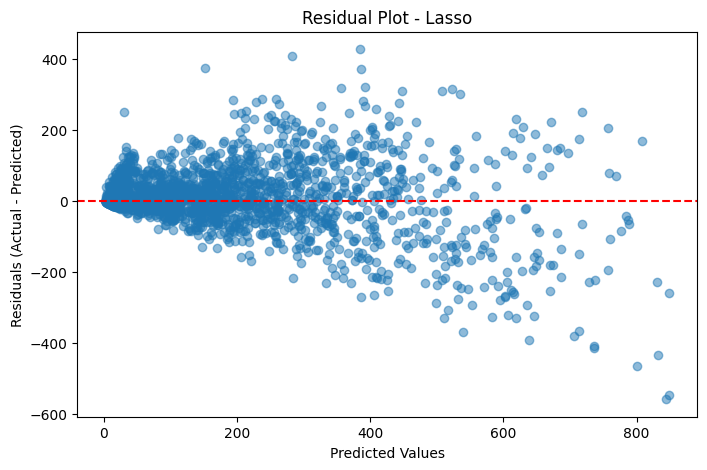

In [16]:
plot_model_residual("Lasso", y_test, y_pred)

In [52]:
# ----------------------------------------------------
# Other Models - Models
# ----------------------------------------------------
models_all = {
    # Linear models
    #"Linear Regression": LinearRegression(),
    #"Ridge Regression": Ridge(alpha=1.0),
    #"Lasso Regression": Lasso(alpha=0.001, max_iter=50000),

    # Tree-based models
    "Random Forest": RandomForestRegressor(
        n_estimators=800, max_depth=17,
        min_samples_split=4, min_samples_leaf=2,
        random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=842, learning_rate=0.05,
        max_depth=6, subsample=0.8, colsample_bytree=0.9,
        objective="reg:squarederror",
        tree_method="hist", random_state=42, n_jobs=-1
    )
}

treeProcessor = ColumnTransformer(
    transformers=[
        #("poly", PolynomialFeatures(degree=2, include_bias=False), numeric_poly),
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# ----------------------------------------------------
# Tree Models : Training + evaluation loop
# ----------------------------------------------------
results = {}
model_pipelines = {}
print("Evaluating All Models ...")

for name, model in models_all.items():
    pipeline = Pipeline([
        ("preprocess", clone(treeProcessor)),
        ("regressor", clone(model))
    ])
    
    pipeline.fit(X_train, y_train_log)
    y_pred_log = pipeline.predict(X_test)

    #convert to actual
    y_pred = np.expm1(y_pred_log)
    y_test = np.expm1(y_test_log)
    
    results[name] = evaluate(y_test, y_pred)

    #plot_model_residual(name, y_test, y_pred)
    
    rmsle_score = rmsle(y_test, y_pred)
    model_pipelines[name] = {
            "RMSLE": rmsle_score,
            "pipeline": pipeline
    }

# ----------------------------------------------------
# Tree Models : Print combined results
# ----------------------------------------------------
print(pd.DataFrame(results).T.sort_values("RMSLE"))
#print(pd.DataFrame(model_pipelines).T.sort_values("RMSLE"))


Evaluating All Models ...
                  RMSLE        R2
XGBoost        0.356306  0.958684
Random Forest  0.384968  0.945417


## Summarize Tree models results
| Model              | RMSLE     | Observations |
|--------------------|-----------|--------------|
| Random Forest      | 0.384968  | Major improvement; captures complex patterns; robust and accurate. |
| Gradient Boosting  | 0.356306  | Best RMSLE; slightly better than Random Forest. works well with spikes in data at peak hours|


In [60]:
# ------------------------------------
# BEST MODEL
# ------------------------------------
best_model = min(results, key=lambda m: results[m]["RMSLE"])
best_pipeline = model_pipelines[best_model]["pipeline"]
print("\nBest Model =", best_model)


Best Model = XGBoost


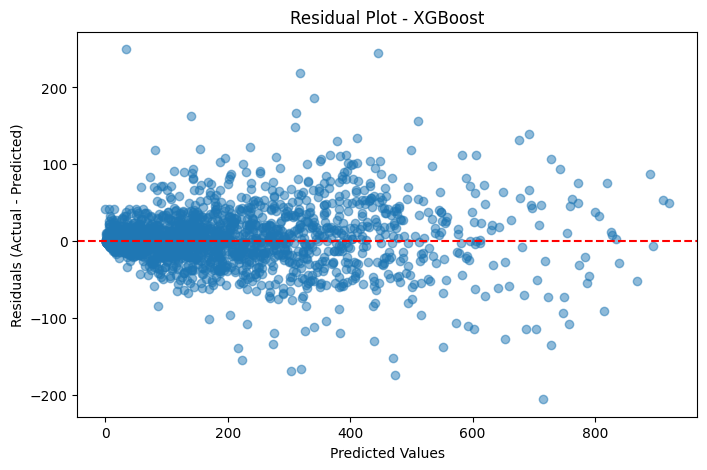

In [61]:
plot_model_residual("XGBoost", y_test, y_pred)

## Q9. Explain why the winning model performs better.

- Best Model - XGBoost

- It is tree-based and captures complex non-linear relationships.
    Bike demand strongly depends on: 
    - - hour of day (cyclical pattern)
    - - month/season (seasonality)
    - - weather-temp interactions
        
    Linear, Ridge, and Lasso cannot capture these interactions.
- It responds to engineered features effectively like hour_sin, hour_cos (cyclical encoding), is_rush_hour and so on</b>
- RMSLE metric rewards Gradient Boosting
 - - RMSLE focuses heavily on relative errors for low-count(night hours) vs sudden spikes (peak hours)
 - - Linear models struggle with spikes → worse RMSLE

## Q10. Why does RMSLE penalize under-predictions more gently than RMSE?
- RMSLE applies the error on the log scale.
- Under-predictions move gently because log compresses values near zero.
- e.g. y=50, predicted=100 then log error = log(51) – log(101) (Overfitting)
- e.g. y=100, predicted=50 then log error = log(101) – log(51) (under-fitting)

## Q11. What are the trade-offs between model simplicity and predictive power?
Ans : <br>
    <ul><li><b>Simple Models : Linear, Ridge & Lasso</b>
    <ol><li> Pros : fast to train, simple and easy to understand.
    <li>Cons : Cannot model nonlinear patterns. Miss seasonality, peaks, weather interactions
    </ol>
    <li><b>Complex Models : Random Forest, Gradient Boosting</b>
    <ol><li> Pros : Capture nonlinear relationships, understand feature engineering
    <li>Cons : complex, hard to understand, computationally expensive
    </ol>

## Q12. Why can’t Linear Regression alone capture time-of-day effects effectively?
Ans : <br>
    <ul>
    <li>Linear Regression assumes straight-line relationship between features and target. 
    <li> i.e. demand = a + b × hour
    <li> It can not learn cyclical patterns like for hour after 0,1,2,...,23 again 0,1,2... starts
    <li>Time of day (hour) affects bike demand in a highly nonlinear pattern (peaks in morning & evening)
    </ul>

## Predict bite_test.csv

In [49]:
# ------------------------------------
# 7. LOAD TEST CSV
# ------------------------------------
bike_test = pd.read_csv("bike_test.csv")
print("Test data shape:", bike_test.shape)


Test data shape: (2613, 9)


In [50]:
print('\n--------- Describe Data ---------')
display(bike_test.describe())

show_datatypes(bike_test)

show_Missing(bike_test)

show_distinct(bike_test)

show_dates(bike_test)


--------- Describe Data ---------


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000
mean,2.509759,0.032912,0.683506,1.437046,20.247516,23.691936,61.980100,13.043217
std,1.113917,0.178441,0.465197,0.639108,7.812128,8.525166,19.252244,8.387861
min,1.000000,0.000000,0.000000,1.000000,1.466819,3.030000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,20.057846,23.743546,62.000000,12.998000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,17.634405
max,4.000000,1.000000,1.000000,3.000000,38.540000,44.555405,100.000000,56.996900


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2613 entries, 0 to 2612
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    2613 non-null   object 
 1   season      2613 non-null   int64  
 2   holiday     2613 non-null   int64  
 3   workingday  2613 non-null   int64  
 4   weather     2613 non-null   int64  
 5   temp        2613 non-null   float64
 6   atemp       2613 non-null   float64
 7   humidity    2613 non-null   int64  
 8   windspeed   2613 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 183.9+ KB
 Data Types : 

None
----------------------------------------
----------------------------------------
 Missing values : 
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64
----------------------------------------
------------------

In [24]:
# save datetime
datetime_backup = bike_test["datetime"]

bike_test = add_datetime_features(bike_test, dateformat_test)
print("After - Test data shape :", bike_test.shape)
X_test_final = bike_test[all_features]
print("Test - X final shape :", X_test_final.shape)
X_test_final.head()

Test data shape: (2613, 9)
After - Test data shape : (2613, 21)
Test - X final shape : (2613, 15)


,temp,humidity,windspeed,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,temp_humidity,weather,holiday,workingday,year,is_rush_hour
0,19.680000,82,11.00140,0.965926,2.588190e-01,0.781831,0.623490,1.224647e-16,-1.000000e+00,-1594.080000,3,0,1,2012,0
1,18.040000,33,19.00120,-0.965926,2.588190e-01,-0.974928,-0.222521,1.000000e+00,6.123234e-17,-577.280000,1,0,0,2011,1
2,13.885038,68,29.52646,1.000000,6.123234e-17,0.000000,1.000000,8.660254e-01,-5.000000e-01,-930.297541,1,0,1,2012,0
3,30.340000,48,8.99810,-0.866025,5.000000e-01,-0.433884,-0.900969,-5.000000e-01,-8.660254e-01,-1425.980000,1,0,1,2012,0
4,18.040000,72,7.00150,-0.965926,2.588190e-01,0.974928,-0.222521,-5.000000e-01,8.660254e-01,-1280.840000,1,0,1,2011,1


In [26]:

# ------------------------------------
# 8. PREDICT 
# ------------------------------------
y_pred_log = pipe_poly2.predict(X_test_final)
#convert to actual
y_pred = np.expm1(y_pred_log)

submission_df = pd.DataFrame({
    "datetime": datetime_backup,
    "count_predicted": y_pred.round().astype(int)
})
submission_df.to_csv("submission.csv", index=False)
print("submission.csv generated successfully!")

print(submission_df.head())
print(submission_df.tail())

submission.csv generated successfully!
           datetime  count_predicted
0   05-06-2012 5:00               16
1  19-03-2011 19:00              159
2   02-04-2012 6:00               26
3  13-07-2012 20:00              406
4  09-11-2011 19:00              393
              datetime  count_predicted
2608   07-11-2012 5:00               18
2609  16-12-2011 05:00               13
2610  14-01-2011 23:00               25
2611  19-02-2011 09:00               55
2612  17-03-2012 05:00               18


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_feature_importance(name, models_all, numeric_other, categorical, X_train, X_test, y_train):
    # 1. Choose a model
    #model_name = "Random Forest"   # or "XGBoost"
    model_name = name
    model = models_all[model_name] # get the model object
    
    # 2. Fit the model on preprocessed data
    # Transform features only, to get feature matrix
    X_train_transformed = preprocess.fit_transform(X_train)
    X_test_transformed = preprocess.transform(X_test)
    
    # Fit the model on transformed data
    model_clone = clone(model)
    model_clone.fit(X_train_transformed, y_train)
    
    # 3. Get feature names
    # Polynomial feature names
    poly_features = preprocess.named_transformers_['poly'].get_feature_names_out(numeric_poly)
    
    # Scaled numeric features
    numeric_features = numeric_other
    
    # OneHot categorical features
    cat_features = preprocess.named_transformers_['cat'].get_feature_names_out(categorical)
    
    # Combine all
    all_features = np.concatenate([poly_features, numeric_features, cat_features])
    
    # 4. Get feature importances
    if hasattr(model_clone, 'feature_importances_'):
        importances = model_clone.feature_importances_
    else:
        raise ValueError(f"{model_name} does not have feature_importances_ attribute")
    
    # 5. Plot
    fi_df = pd.DataFrame({"feature": all_features, "importance": importances})
    fi_df = fi_df.sort_values("importance", ascending=False).head(20)  # top 20 features
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="importance", y="feature",  hue="feature", data=fi_df, palette="viridis", legend=False)
    plt.title(f"Top 20 Feature Importances — {model_name}")
    plt.tight_layout()
    plt.show()

In [ ]:
# Call it - "Random Forest"   # or "XGBoost"
plot_feature_importance("XGBoost" , models_all, numeric_features, categorical_features, X_train, X_test, y_train)
#plot_feature_importance("Random Forest" , models_all, numeric_poly, numeric_other, categorical, X_train, X_test, y_train)